**LAB: SENTIMENT ANALYSIS - Supervised Machine Learning**

We'll use a movie reviews dataset provided on the Blackboard. Look inside of the folder to see how the data are organized. 

Set the path to the reviews folder to use later in the script:

In [10]:
path = '/Users/corrine/Documents/Data Courses/Text Mining'

NOTE: We'll use the text normalization function defined earlier in the course. The function is defined in Text_Normalization_Function.ipynb notebook. The Text_Normalization_Function.ipynb file should be in the same folder as the notebook you are using right now. The following line 

In [2]:
%run ./Text_Normalization_Function.ipynb

Original:   <p>The circus dog in a plissé skirt jumped over Python who wasn't that large, just 3 feet long.</p>
Processed:  ['<', 'p', '>', 'The', 'circus', 'dog', 'in', 'a', 'plissé', 'skirt', 'jumped', 'over', 'Python', 'who', 'was', "n't", 'that', 'large', ',', 'just', '3', 'feet', 'long.', '<', '/p', '>']
Original:   <p>The circus dog in a plissé skirt jumped over Python who wasn't that large, just 3 feet long.</p>
Processed:  <p>The circus dog in a plissé skirt jumped over Python who was not that large, just 3 feet long.</p>
Original:   <p>The circus dog in a plissé skirt jumped over Python who wasn't that large, just 3 feet long.</p>
Processed:  [('<', 'a'), ('p', 'n'), ('>', 'v'), ('the', None), ('circus', 'n'), ('dog', 'n'), ('in', None), ('a', None), ('plissé', 'n'), ('skirt', 'n'), ('jumped', 'v'), ('over', None), ('python', 'n'), ('who', None), ('was', 'v'), ("n't", 'r'), ('that', None), ('large', 'a'), (',', None), ('just', 'r'), ('3', None), ('feet', 'n'), ('long.', 'a'), 

Make sure the text normalization function is working properly by running it on the test corpus below:

In [3]:
test_text = "<p>The circus dog in a plissé skirt jumped over Python who wasn't that large, just 3 feet long.</p>"
test_corpus = [test_text]
test_corpus.append(test_text)
normalized_test_corpus = normalize_corpus(test_corpus)

print("Original corpus:  ", test_corpus,"\n")
print("Processed corpus: ", normalize_corpus(test_corpus))

Original corpus:   ["<p>The circus dog in a plissé skirt jumped over Python who wasn't that large, just 3 feet long.</p>", "<p>The circus dog in a plissé skirt jumped over Python who wasn't that large, just 3 feet long.</p>"] 

Processed corpus:  ['circus dog plisse skirt jump python large foot long', 'circus dog plisse skirt jump python large foot long']


Import the modules we'll use:

In [4]:
from sklearn import metrics 
import numpy as np 
import pandas as pd 
import glob, os  
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 

Read the data:
... training data for negative reviews:

In [11]:
train_reviews_neg = glob.glob(path + '/reviews/train/neg/*.txt')
d_neg = list()
for review_file in train_reviews_neg:
    with open(review_file) as f:
        review = os.path.basename(review_file)
        d_neg.append(pd.DataFrame({'file_name': review, 'review_text': f.readlines(), 'polarity': 'negative'}))

... training data for positive reviews:

In [12]:
train_reviews_pos = glob.glob(path + '/reviews/train/pos/*.txt')
d_pos = list()
for review_file in train_reviews_pos:
    with open(review_file) as f:
        review = os.path.basename(review_file)
        d_pos.append(pd.DataFrame({'file_name': review, 'review_text': f.readlines(), 'polarity': 'positive'}))

Combine positive and negative training sets:

In [13]:
doc_train = pd.concat(d_pos + d_neg)
print("Train data shape: ", doc_train.shape)
doc_train.head()

Train data shape:  (1000, 3)


,file_name,review_text,polarity
0,12390_8.txt,Bizarre horror movie filled with famous faces ...,positive
0,58_9.txt,Caught the tail end of this movie channel surf...,positive
0,12480_10.txt,"this movie has a great message,a impressive ca...",positive
0,72_7.txt,I just recently watched this 1954 movie starri...,positive
0,165_7.txt,One of my favorite scenes is at the beginning ...,positive


Read the test dataset:

In [14]:
test_reviews_pos = glob.glob(path + '/reviews/test/pos/*.txt')
test_d_pos = list()
for review_file in test_reviews_pos:
    with open(review_file) as f:
        review = os.path.basename(review_file)
        test_d_pos.append(pd.DataFrame({'file_name': review, 'review_text': f.readlines(), 'polarity': 'positive'}))

In [15]:
test_reviews_neg = glob.glob(path + '/reviews/test/neg/*.txt')
test_d_neg = list()
for review_file in test_reviews_neg:
    with open(review_file) as f:
        review = os.path.basename(review_file)
        test_d_neg.append(pd.DataFrame({'file_name': review, 'review_text': f.readlines(), 'polarity': 'negative'}))

In [16]:
doc_test = pd.concat(test_d_pos + test_d_neg)
print("Test data shape: ", doc_test.shape)
doc_test.head()

Test data shape:  (1000, 3)


,file_name,review_text,polarity
0,147_10.txt,"Of the Korean movies I've seen, only three had...",positive
0,12363_7.txt,I have just finished watching this film for th...,positive
0,165_7.txt,Three children are born during a solar eclipse...,positive
0,159_10.txt,"If you love Chan-wook Park, you know what to e...",positive
0,198_7.txt,Russian actress TATIANA SAMOILOVA reminds me s...,positive


In [17]:
norm_reviews_train = normalize_corpus(doc_train['review_text'])
norm_reviews_test = normalize_corpus(doc_test['review_text'])

In [18]:
print('RAW TEXT: ', np.array(doc_test['review_text'])[0])
print()
print('NORMALIZED TEXT: ', norm_reviews_test[0])

RAW TEXT:  Of the Korean movies I've seen, only three had really stuck with me. The first is the excellent horror A Tale of Two Sisters. The second and third - and now fourth too - have all been Park Chan Wook's movies, namely Oldboy, Sympathy for Lady Vengeance), and now Thirst. <br /><br />Park kinda reminds me of Quentin Tarantino with his irreverence towards convention. All his movies are shocking, but not in a gratuitous sense. It's more like he shows us what we don't expect to see - typically situations that go radically against society's morals, like incest or a libidinous, blood-sucking, yet devout priest. He's also quite artistically-inclined with regards to cinematography, and his movies are among the more gorgeous that I've seen.<br /><br />Thirst is all that - being about said priest and the repressed, conscience-less woman he falls for - and more. It's horror, drama, and even comedy, as Park disarms his audience with many inappropriate yet humorous situations. As such, thi

Create features (vectorize text data) using tfidf approach and choose n-gram size (e.g., option ngram_range = (1,2) will creat uni-grams and bi-grams while option ngram_range = (2,2) will creat only bi-grams). 

We will create two models of text, one with uni-grams and bi-grams (original) and one with uni-grams only (alternative):

In [19]:
vectorizer = TfidfVectorizer(ngram_range = (1,2)) 
feature_matrix_TRAIN = vectorizer.fit_transform(norm_reviews_train).astype(float)

vectorizer_alt = TfidfVectorizer(ngram_range = (1,1)) 
feature_matrix_TRAIN_alt = vectorizer_alt.fit_transform(norm_reviews_train).astype(float)

Have a look at the feature matrix with unigrams and bi-grams for the training data (vectorized training data) and note the n-grams:

In [20]:
feature_matrix_TRAIN_names = vectorizer.get_feature_names() 
feature_matrix_TRAIN_table = pd.DataFrame(data = feature_matrix_TRAIN.todense(), 
                                          columns = feature_matrix_TRAIN_names)
feature_matrix_TRAIN_table.head(5)

,00pm,00pm castro,00pm us,100m,100m budget,100th,100th grade,13th,13th film,13th part,...,zorro,zorro hell,zsigmond,zsigmond future,zu,zu neuen,zu warrior,zu xian,zumhofe,zumhofe look
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Vectorize testing data using the features created based on the training data:

In [21]:
feature_matrix_TEST = vectorizer.transform(norm_reviews_test)
feature_matrix_TEST_alt = vectorizer_alt.transform(norm_reviews_test)

Estimate the the classification model for sentiment analysis based on Support Vector Machines method and do prediction of sentiment polarity for the test data:

In [22]:
from sklearn import linear_model

sent_analysis_svm = linear_model.SGDClassifier(loss='hinge') 
sent_analysis_svm.fit(feature_matrix_TRAIN, doc_train['polarity'])
predicted_svm = sent_analysis_svm.predict(feature_matrix_TEST) 

sent_analysis_svm_alt = linear_model.SGDClassifier(loss='hinge') 
sent_analysis_svm_alt.fit(feature_matrix_TRAIN_alt, doc_train['polarity'])
predicted_svm_alt = sent_analysis_svm_alt.predict(feature_matrix_TEST_alt)  

For a sample of reviews in the test data, show the actual and predicted sentiment polarity:

In [23]:
sample_ids = [0, 30, 330, 851, 951, 995] 

In [24]:
for doc_index in sample_ids:
    print('Review:-')
    print(np.array(doc_test['review_text'])[doc_index])
    print('Actual Labeled Sentiment:', np.array(doc_test['polarity'])[doc_index])
    print('Predicted Sentiment:', predicted_svm[doc_index])   
    print()

Review:-
Of the Korean movies I've seen, only three had really stuck with me. The first is the excellent horror A Tale of Two Sisters. The second and third - and now fourth too - have all been Park Chan Wook's movies, namely Oldboy, Sympathy for Lady Vengeance), and now Thirst. <br /><br />Park kinda reminds me of Quentin Tarantino with his irreverence towards convention. All his movies are shocking, but not in a gratuitous sense. It's more like he shows us what we don't expect to see - typically situations that go radically against society's morals, like incest or a libidinous, blood-sucking, yet devout priest. He's also quite artistically-inclined with regards to cinematography, and his movies are among the more gorgeous that I've seen.<br /><br />Thirst is all that - being about said priest and the repressed, conscience-less woman he falls for - and more. It's horror, drama, and even comedy, as Park disarms his audience with many inappropriate yet humorous situations. As such, this 

**EXERCISE 1: Play with sample_ids to display actual and predicted sentiment polarity for different reviews. Try to develop some intuition on why the machine makes prediction mistakes.**

The second review which is labeled positive but predicted negative has large portion of descriptions of the movie which contains negative words a lot. Only one sentence at last shows his attitude. THe machine cannot distinguish the negative words for the description of movie or for expression of  his sentiment.

Compute the accuracy metrics (accuracy score, recall, and precision) for the sentiment prediction based on the combination of uni-grams and bi-grams:

In [25]:
from sklearn import metrics

true_labels = doc_test['polarity']
predicted_labels = predicted_svm
positive_class = 'positive'

print('Accuracy:', np.round(metrics.accuracy_score(true_labels, 
                                                        predicted_labels), 2))

print('Precision:', np.round(metrics.precision_score(true_labels, 
                                                          predicted_labels, 
                                                          pos_label=positive_class, 
                                                          average='binary'), 2)) 

print('Recall:', np.round(metrics.recall_score(true_labels, 
                                                   predicted_labels, 
                                                   pos_label=positive_class, 
                                                   average='binary'), 2)) 

Accuracy: 0.8
Precision: 0.88
Recall: 0.69


**BOOTSTRAPPING FOR MODEL COMPARISON:**

In [26]:
import numpy as np
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

Configure bootstrap: select number of iterations, sample size and generate observation ids:

In [27]:
n_iterations = 100
n_size = 1000
ids = range(1000)

Display the accuracy for the original and the alternative models, as well as the difference in accuracy, delta:

In [28]:
svm_accuracy = np.round(metrics.accuracy_score(np.array(doc_test['polarity']), predicted_svm), 3)
svm_accuracy_alt = np.round(metrics.accuracy_score(np.array(doc_test['polarity']), predicted_svm_alt), 3)
delta_test = svm_accuracy - svm_accuracy_alt
print("Accuracy prediction, original: ", svm_accuracy)
print("Accuracy prediction, alternative: ", svm_accuracy_alt)
print("Difference in accuracy prediction: ", delta_test)

Accuracy prediction, original:  0.798
Accuracy prediction, alternative:  0.77
Difference in accuracy prediction:  0.028000000000000025


Run the bootstrap:

In [29]:
svm_accuracy_boot = list()
svm_accuracy_boot_alt = list()
s = 0

for i in range(n_iterations):
    
    #prepare a pseudo test set
    test_ids = resample(ids, n_samples = n_size)
    actual_sentiments = np.array(doc_test['polarity'])[test_ids]
    
    #compute predictions on the pseudo sample
    svm_predicted = sent_analysis_svm.predict(feature_matrix_TEST[test_ids])
    svm_predicted_alt = sent_analysis_svm_alt.predict(feature_matrix_TEST_alt[test_ids])
    
    #compute accuracy for the pseudo sample
    svm_accuracy_boot_iter = metrics.accuracy_score(np.array(doc_test['polarity'])[test_ids], svm_predicted)
    svm_accuracy_boot_iter_alt = metrics.accuracy_score(np.array(doc_test['polarity'])[test_ids], svm_predicted_alt)

    delta = svm_accuracy_boot_iter - svm_accuracy_boot_iter_alt
    
    if delta > 2*delta_test:
        s = s+1
    
    pvalue = float(s)/n_iterations
    
    svm_accuracy_boot.append(svm_accuracy_boot_iter)
    svm_accuracy_boot_alt.append(svm_accuracy_boot_iter_alt)

Have a look at the p-value and the mean performance (accuracy) of the two models on the bootstrapped test datasets.
 
Interpretation of the p-value: What is the probability that we will reject the null hypothesis? The null hypothesis: the original model A is no better than the alternative model B).

p-value:  0.01
Mean accuracy for Original Model:  0.798
Mean accuracy for Alternative Model:  0.77


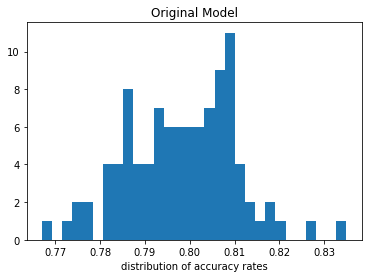

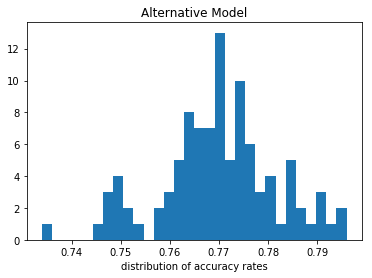

In [30]:
print('p-value: ', pvalue)
print('Mean accuracy for Original Model: ', np.round(np.mean(svm_accuracy_boot),3))
print('Mean accuracy for Alternative Model: ', np.round(np.mean(svm_accuracy_boot_alt),3))


import matplotlib.pyplot as plt

plt.hist(svm_accuracy_boot,bins = 30)
plt.xlabel("distribution of accuracy rates")
plt.title("Original Model")
plt.show()

plt.hist(svm_accuracy_boot_alt,bins = 30)
plt.xlabel("distribution of accuracy rates")
plt.title("Alternative Model")
plt.show()

Let's visualize the performance (accuracy) of the two models on the bostrapped test datasets by plotting the accuracy rates: 

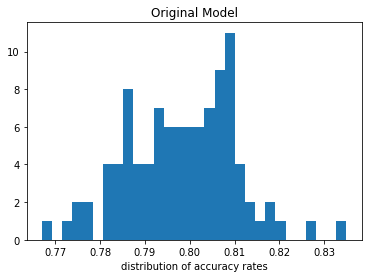

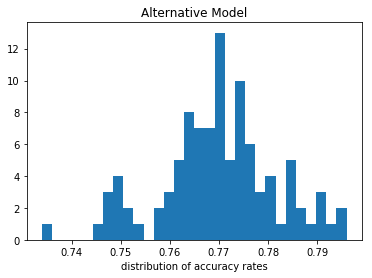

In [31]:
import matplotlib.pyplot as plt

plt.hist(svm_accuracy_boot,bins = 30)
plt.xlabel("distribution of accuracy rates")
plt.title("Original Model")
plt.show()

plt.hist(svm_accuracy_boot_alt,bins = 30)
plt.xlabel("distribution of accuracy rates")
plt.title("Alternative Model")
plt.show()

**EXERCISE 2: Suggest and bootstrap-test a different model of sentiment polarity prediction using supervised machine learning techniques. You can consider a different fitting method (e.g., Naive Bayes or logit) or create features differently (e.g., use "bag-of-words").**

In [32]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=0.1) 
clf.fit(feature_matrix_TRAIN, doc_train['polarity'])
predicted_nb = clf.predict(feature_matrix_TEST)

In [33]:
clf_alt = MultinomialNB(alpha=0.1) 
clf_alt.fit(feature_matrix_TRAIN_alt, doc_train['polarity'])
predicted_nb_alt = clf_alt.predict(feature_matrix_TEST_alt)


In [34]:
nb_accuracy = np.round(metrics.accuracy_score(np.array(doc_test['polarity']), predicted_nb), 3)
nb_accuracy_alt = np.round(metrics.accuracy_score(np.array(doc_test['polarity']), predicted_nb_alt), 3)
delta_test = nb_accuracy - nb_accuracy_alt

In [35]:
nb_accuracy_boot = list()
nb_accuracy_boot_alt = list()
s = 0

for i in range(n_iterations):
    
    #prepare a pseudo test set
    test_ids = resample(ids, n_samples = n_size)
    actual_sentiments = np.array(doc_test['polarity'])[test_ids]
    
    #compute predictions on the pseudo sample
    nb_predicted = clf.predict(feature_matrix_TEST[test_ids])
    nb_predicted_alt = clf_alt.predict(feature_matrix_TEST_alt[test_ids])
    
    #compute accuracy for the pseudo sample
    nb_accuracy_boot_iter = metrics.accuracy_score(np.array(doc_test['polarity'])[test_ids], nb_predicted)
    nb_accuracy_boot_iter_alt = metrics.accuracy_score(np.array(doc_test['polarity'])[test_ids], nb_predicted_alt)

    delta = nb_accuracy_boot_iter - nb_accuracy_boot_iter_alt
    
    if delta > 2*delta_test:
        s = s+1
    
    pvalue = float(s)/n_iterations
    
    nb_accuracy_boot.append(nb_accuracy_boot_iter)
    nb_accuracy_boot_alt.append(nb_accuracy_boot_iter_alt)

In [37]:
print('p-value: ', pvalue)
print('Mean accuracy for Original Model: ', np.round(np.mean(nb_accuracy_boot),3))
print('Mean accuracy for Alternative Model: ', np.round(np.mean(nb_accuracy_boot_alt),3))

p-value:  0.0
Mean accuracy for Original Model:  0.766
Mean accuracy for Alternative Model:  0.74


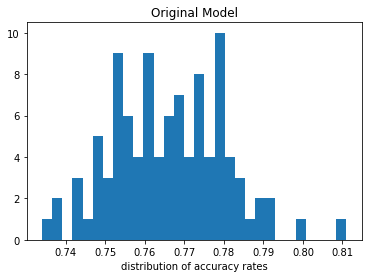

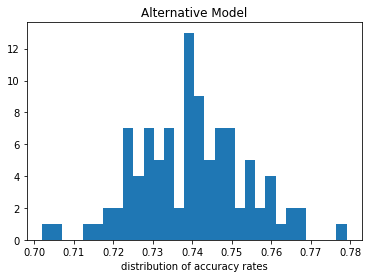

In [38]:
import matplotlib.pyplot as plt

plt.hist(nb_accuracy_boot,bins = 30)
plt.xlabel("distribution of accuracy rates")
plt.title("Original Model")
plt.show()

plt.hist(nb_accuracy_boot_alt,bins = 30)
plt.xlabel("distribution of accuracy rates")
plt.title("Alternative Model")
plt.show()